## COMP41680 Assignment 2

## Student number: 20200155
## Student name: Kshitija Shelar

## Task 1
### Gathering data from urls, fetching data from all the pages and generating csv file from the collected data

### Importing libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sb
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


### Making a list of month to pass in placholder later to fetch urls for different months.

In [2]:
list_mon =["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
list_of_cat = ['Politics','Film','Business']  # list of categories considered for this assignment
articles=[]  # a list to store news articles

### Function to fetch text from all the pages from a particular month's url

In [3]:
def fetch_data_from_URL(r,month,page):
  for num in range(1,page):
    pageNumber = ("00" + str(num))[-3:]
    URL = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-%s-%s.html"%(month,pageNumber)
    r = requests.get(URL)
    soup = BeautifulSoup(r.content, 'html5lib')
    table = soup.find('div', attrs = {'id':'all'}) 
    get_text_and_make_csv(table)

### Function to read the rows i.e news and fetching title,snippet and category and storing in a dictonary and then appending to list of articles 

In [4]:
def get_text_and_make_csv(table):
  for row in table.findAll('div', attrs = {'class':'article'}):
    article = {}
    label = row.find_all('p', class_='metadata')[1].text.split(":")[1].replace(" ","")
    if( label in list_of_cat):
      article['title'] = row.h5.text.replace('\xa0[0-9]','')
      article['snippet']=row.find_all('p', class_='snippet')[0].text
      article['label']=label
      articles.append(article)

### Sending request to the urls for fetching data for every month as well as finding out how many page number it has.

In [5]:
for month in list_mon:
  URL = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-%s-001.html"%(month)
  r = requests.get(URL)
  soup = BeautifulSoup(r.content, 'html5lib')
  name = soup.find('h4', attrs={'class': 'results'})
  page = int(name.text.split(" ")[-1])
  fetch_data_from_URL(r,month,page)

### Making a csv file with the datat fetched from the website by writing it from the dictionary to the csv file.

In [6]:
filename = 'news.csv'
with open(filename, 'w', newline='') as f:
  w = csv.DictWriter(f,['title','snippet','label'])
  w.writeheader()
  for article in articles:
    w.writerow(article)

### Loading data from csv to dataframe

In [7]:
df = pd.read_csv("news.csv")


In [8]:
df.head()

,title,snippet,label
0,6. Zero-carbon electricity outstrips fossil fu...,Summary: Zero-carbon energy became Britain’s l...,Business
1,"8. War epics, airmen and young Sopranos: essen...",1917 An epic of Lean-ian proportions is delive...,Film
2,12. The most exciting movies of 2020 – horror,The Grudge A belated English language reboot o...,Film
3,"14. US election, Brexit and China to sway the ...","After profiting from strong markets in 2019, i...",Business
4,16. Clive Lewis calls for unity among Labour l...,Summary: The Labour leadership hopeful Clive L...,Politics


### Making list of stop words to later clean the data

In [9]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Creating a datafram with the cleaned data (removed 1. 2. and other numbers from title and other unnecessary characters) and merged title and snippet to be one column

In [10]:
document = []
label = []
title = df['title']
snippet = df['snippet']
lbl = df['label']
for i in range(len(df)):
  doc = title[i] + snippet[i]
  doc = re.sub('[0-9.]', '', doc)
  doc = re.sub('\xa0','',doc)
  document.append(doc)
  label.append(lbl[i])


In [11]:
data_frame = list(zip(document,label))

In [12]:
data_frame = pd.DataFrame(data_frame, columns=['Title','Category'])

In [13]:
data_frame.head()


,Title,Category
0,Zero-carbon electricity outstrips fossil fuels...,Business
1,"War epics, airmen and young Sopranos: essentia...",Film
2,The most exciting movies of – horrorThe Grudg...,Film
3,"US election, Brexit and China to sway the mark...",Business
4,Clive Lewis calls for unity among Labour leade...,Politics


## Task 2 
### Creating 3 seperate data frames with combinations of categories chosen. Here the combinations are Politics and Film, Film and Buisness, and Politics and Buisness.

In [14]:
df1 = data_frame[data_frame['Category'] != "Business"]


In [15]:
df2 = data_frame[data_frame['Category'] != "Politics"]

In [16]:
df3 = data_frame[data_frame['Category'] != "Film"]


In [17]:
df3.head()

,Title,Category
0,Zero-carbon electricity outstrips fossil fuels...,Business
3,"US election, Brexit and China to sway the mark...",Business
4,Clive Lewis calls for unity among Labour leade...,Politics
5,Greggs launches meatless steak bake to beef up...,Business
6,Sadiq Khan pledges free London travel for disa...,Politics


### Function to clean the text data by removing the punctuation marks, converting everything into lower case and removing the stop words.

In [18]:
import string
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stop_words]
    return text

### Function to perform TFIDF vectorization and training the logistic regression model to perform binary classification and generating the classification report.

In [19]:
def trainNPredict(df, label):
  tfidf_vect = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7,analyzer=clean_text)
  X_tfidf = tfidf_vect.fit_transform(df['Title'])
  X_features =pd.DataFrame(X_tfidf.toarray())
  X_train, X_test, y_train, y_test = train_test_split(X_features, df['Category'], test_size=0.2)
  sb.countplot(y_train)
  plt.show()  
  lr = LogisticRegression(random_state=0).fit(X_train, y_train)
  y_pred=lr.predict(X_test)
  print("classification report : %s"%(label))
  print(metrics.classification_report(y_test , y_pred))
  print("accuracy: ", accuracy_score(y_test, y_pred))
  

In [20]:
dfs = [(df1,'Film & Politics'),(df2,'Business & Film'),(df3,'Politics & Business')]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


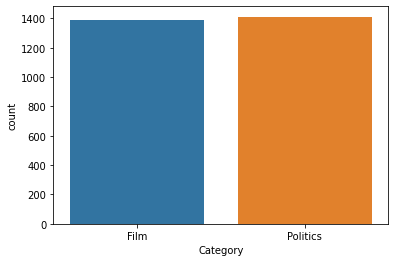

classification report : Film & Politics
              precision    recall  f1-score   support

        Film       0.97      0.99      0.98       351
    Politics       0.99      0.97      0.98       349

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700

accuracy:  0.9757142857142858


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


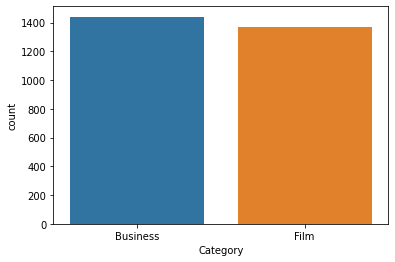

classification report : Business & Film
              precision    recall  f1-score   support

    Business       0.96      0.99      0.97       337
        Film       0.99      0.96      0.97       367

    accuracy                           0.97       704
   macro avg       0.97      0.97      0.97       704
weighted avg       0.97      0.97      0.97       704

accuracy:  0.9730113636363636


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


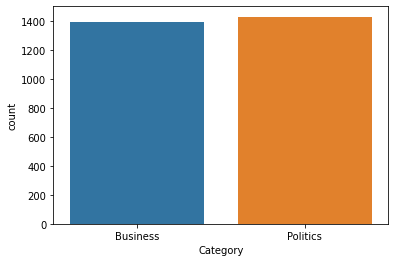

classification report : Politics & Business
              precision    recall  f1-score   support

    Business       0.90      0.92      0.91       381
    Politics       0.91      0.87      0.89       327

    accuracy                           0.90       708
   macro avg       0.90      0.90      0.90       708
weighted avg       0.90      0.90      0.90       708

accuracy:  0.9011299435028248


In [21]:
for df,label in dfs:
  trainNPredict(df,label)

## Task 3

### Using the whole data for training and classifying 3 different categories. Used randomforest classifier for multi class classification.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


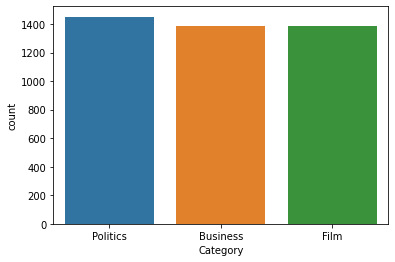

classification report :
              precision    recall  f1-score   support

    Business       0.86      0.79      0.82       392
        Film       0.79      0.97      0.87       355
    Politics       0.91      0.78      0.84       309

    accuracy                           0.85      1056
   macro avg       0.86      0.85      0.85      1056
weighted avg       0.85      0.85      0.85      1056

accuracy:  0.8475378787878788


In [22]:

tfidf_vect = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7,analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data_frame['Title'])
X_features =pd.DataFrame(X_tfidf.toarray())
X_train, X_test, y_train, y_test = train_test_split(X_features, data_frame['Category'], test_size=0.2)
sb.countplot(y_train)
plt.show()  
rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("classification report :")
print(metrics.classification_report(y_test , y_pred))
print("accuracy: ", accuracy_score(y_test, y_pred))

